# Predicting Survival on the Titanic

My first ever EDA on a titanic dataset consisting of various variables, in order to predict whether a passenger in the tragic Titanic accident survived.

In [160]:
%matplotlib inline

# Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing
import sklearn.preprocessing
import missingno

# ML Tools
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


import tensorflow as tf
from tensorflow.keras.layers import Dense

## 1. Loading Data
Loading the data into the notebook.

In [203]:
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")
submission_example = pd.read_csv("../Data/gender_submission.csv")

**i) Get a brief overview of the training data:**

### Data Descriptions:

![image](./description.png)

In [162]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [163]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [164]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [165]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Survived: 342
Perished: 549
Percentage that survived: 38.4%


<AxesSubplot:xlabel='count', ylabel='Survived'>

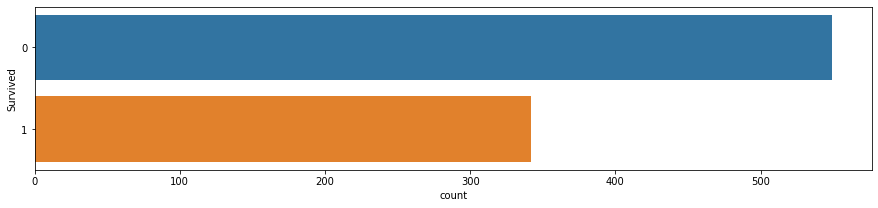

In [166]:
survived = len(train[train['Survived']==1])
perished = len(train[train['Survived']==0])

print("Survived: {}".format(survived))
print("Perished: {}".format(perished))
print("Percentage that survived: {:.1%}".format(survived/(survived+perished)))

fig = plt.figure(figsize=(15,3))
sns.countplot(y='Survived', data=train)

Get an idea of how the prediction should look like:

In [167]:
submission_example.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


**ii) Get more information on the missing Data**

In [168]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

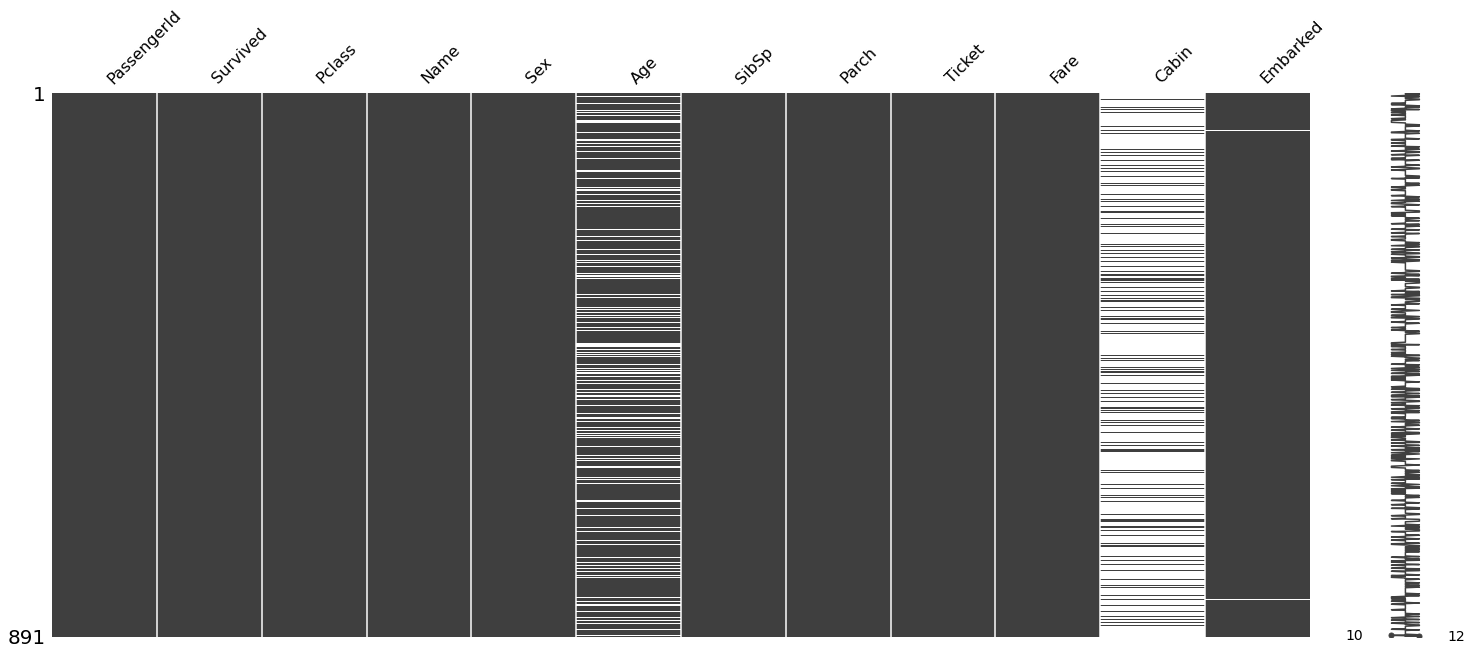

In [169]:
missingno.matrix(train)

In [170]:
# Compute training data where a particular feature has no missing values.



train_w_miss = train.dropna()
train_w_miss_age = train.dropna(subset=['Age'])
train_w_miss_cabin = train.dropna(subset=['Cabin'])
train_w_miss_embarked = train.dropna(subset=['Embarked'])

## 2. Data Processing


In [171]:
# Assign Numerical Values to Strings
train = train_w_miss_embarked

label_encoder = sklearn.preprocessing.LabelEncoder()
train['Sex'] = label_encoder.fit_transform(train['Sex'])
train['Embarked'] = label_encoder.fit_transform(train['Embarked'])
train['Cabin'] = label_encoder.fit_transform(train['Cabin'])


## 3. Machine Learning models

In [172]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_algo(algo, X_train, y_train, cv = 10):
    
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv, model

### i) Logistic Regression

In [173]:
Used_features = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare','SibSp', 'Parch']

X_train = train[Used_features].dropna()
y_train = X_train.Survived
X_train = X_train.drop('Survived', axis = 1)

start_time = time.time()
train_pred_log, acc_log1, acc_cv_log1, _ = fit_algo(LogisticRegression(penalty='l2', random_state=42), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
print("Accuracy: %s" % acc_log1)
print("Accuracy CV 10-Fold: %s" % acc_cv_log1)


Accuracy: 80.2
Accuracy CV 10-Fold: 79.63


In [174]:
# Scaling the Age and Fare

Used_features = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'SibSp', 'Parch']

X_train = train[Used_features].dropna()
y_train = X_train.Survived
X_train = X_train.drop('Survived', axis = 1)

X_train[['Age', 'Fare']] = sklearn.preprocessing.StandardScaler().fit_transform(X_train[['Age', 'Fare']] )



start_time = time.time()
train_pred_log, acc_log2, acc_cv_log2, _ = fit_algo(LogisticRegression(penalty='l2', random_state=42), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
print("Accuracy: %s" % acc_log2)
print("Accuracy CV 10-Fold: %s" % acc_cv_log2)

Accuracy: 80.48
Accuracy CV 10-Fold: 79.49


### ii) k-Nearest Neighbors

In [175]:
X_train

,Pclass,Sex,Age,Fare,Embarked,SibSp,Parch
0,3,1,-0.527669,-0.516380,2,1,0
1,1,0,0.577094,0.694046,0,1,0
2,3,0,-0.251478,-0.503620,2,0,0
3,1,0,0.369951,0.350326,2,1,0
4,3,1,0.369951,-0.501257,2,0,0
...,...,...,...,...,...,...,...
885,3,0,0.646142,-0.102875,1,0,5
886,2,1,-0.182430,-0.407687,2,0,0
887,1,0,-0.734812,-0.086335,2,0,0
889,1,1,-0.251478,-0.086335,0,0,0


In [176]:
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn, knn_model = fit_algo(KNeighborsClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)

print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)

Accuracy: 85.96
Accuracy CV 10-Fold: 79.92


### iii) Decision Trees

In [177]:
train_pred_dt, acc_dt, acc_cv_dt, dt_model = fit_algo(DecisionTreeClassifier(max_depth=7, min_samples_split=4), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)


Accuracy: 87.64
Accuracy CV 10-Fold: 79.49


### iv) Neural Networks 

In [178]:
epoch = 200

model = tf.keras.Sequential([
    Dense(128, activation = 'relu', name = 'Layer1'),
    Dense(32, activation = 'relu', name = 'Layer2'),
    Dense(2, activation = 'softmax', name = 'Layer4')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=epoch, verbose=0)

acc_nn = round(model.history.history['accuracy'][-1]*100,2)

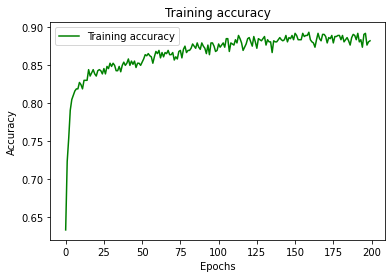

In [179]:
accuracy_train = model.history.history['accuracy']
epochs_ = range(epoch)
plt.plot(epochs_, accuracy_train, 'g', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 4. Comparing Models

In [180]:
models = pd.DataFrame({
    'Model': ['Logistic Regression without Normalization', 'Logistic Regression with Normalization', 'k-nearest Neighbor', 'Decision Tree', 'Neural Network'],
    'Score': [acc_log1,
              acc_log1,
              acc_knn,
              acc_dt,
              acc_nn
       
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
4,Neural Network,88.20
3,Decision Tree,87.64
2,k-nearest Neighbor,85.96
0,Logistic Regression without Normalization,80.20
1,Logistic Regression with Normalization,80.20


In [181]:
cv_models = pd.DataFrame({
    'Model': ['Logistic Regression without Normalization', 'Logistic Regression with Normalization', 'k-nearest Neighbor', 'Decision Tree'],

    'Score': [
        acc_cv_log1, 
        acc_cv_log2,      
        acc_cv_knn,
        acc_cv_dt,
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)


---Cross-validation Accuracy Scores---


,Model,Score
2,k-nearest Neighbor,79.92
0,Logistic Regression without Normalization,79.63
1,Logistic Regression with Normalization,79.49
3,Decision Tree,79.49


In [182]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## 5. Creating Submission

In [204]:
X_test = test[Used_features[1:]]
X_test.head()

,Pclass,Sex,Age,Fare,Embarked,SibSp,Parch
0,3,male,34.5,7.8292,Q,0,0
1,3,female,47.0,7.0000,S,1,0
2,2,male,62.0,9.6875,Q,0,0
3,3,male,27.0,8.6625,S,0,0
4,3,female,22.0,12.2875,S,1,1


In [205]:
X_test = X_test[Used_features[1:]]

label_encoder = sklearn.preprocessing.LabelEncoder()
X_test['Sex'] = label_encoder.fit_transform(X_test['Sex'])
X_test['Embarked'] = label_encoder.fit_transform(X_test['Embarked'])

X_test[['Age', 'Fare']] = sklearn.preprocessing.StandardScaler().fit_transform(X_test[['Age', 'Fare']] )

In [206]:
X_test.isna().sum()

Pclass       0
Sex          0
Age         86
Fare         1
Embarked     0
SibSp        0
Parch        0
dtype: int64

In [207]:
age_mean = X_test['Age'].mean()
fare_mean = X_test['Fare'].mean()

X_test['Age'].fillna(value=age_mean, inplace=True)
X_test['Fare'].fillna(value=fare_mean, inplace=True)

In [208]:
X_test.head()

,Pclass,Sex,Age,Fare,Embarked,SibSp,Parch
0,3,1,0.298549,-0.497811,1,0,0
1,3,0,1.181328,-0.512660,2,1,0
2,2,1,2.240662,-0.464532,1,0,0
3,3,1,-0.231118,-0.482888,2,0,0
4,3,0,-0.584229,-0.417971,2,1,1


In [209]:
# Using knn Algorithm
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = knn_model.predict(X_test) 
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [211]:
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('../submission.csv', index=False)